In [1]:
# Download dataset Informasi Unib yang berformat json dari GitHub
from urllib import request
url = "https://raw.githubusercontent.com/marsahulwa/UAS-DEEP-LEARNING/refs/heads/main/chatbot_InformasiUNIB.json"
request.urlretrieve(url, "chatbot_InformasiUnib.json")

('chatbot_InformasiUnib.json', <http.client.HTTPMessage at 0x7f4a052a26e0>)

In [2]:
#Menghubungkan Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [5]:
import nltk #import library nltk

# Download the 'punkt' package untuk word tokenization.
nltk.download('punkt')
# Download the 'punkt_tab' package untuk sentence tokenization.
nltk.download('punkt_tab')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:
# Import dataset
with open('/content/chatbot_InformasiUnib.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter
# Tambahkan data intents dalam json
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    # digunakan untuk pattern atau teks pertanyaan dalam json
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # tambahkan ke dalam list kelas dalam data
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [7]:
# Cetak data keseluruhan
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,selamat pagi,greeting
4,pagi,greeting
...,...,...
59,oke,goodbye
60,thankyou,goodbye
61,stop,goodbye
62,ok,goodbye


In [8]:
# Menghilangkan Punktuasi
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

In [9]:
#membuat lemmas dari kata
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

81 unique lemmatized words ['.', '2024', 'ada', 'akademik', 'alamat', 'apa', 'bagaimana', 'bengkulu', 'berdirinya', 'berita', 'berlaku', 'biro', 'bye', 'cara', 'ceritakan', 'daftar', 'dalam', 'dan', 'dari', 'dengan', 'di', 'dulu', 'fakultas', 'fungsi', 'hai', 'hallo', 'halo', 'indonesia', 'itu', 'kasih', 'lembaga', 'malam', 'medium', 'mendukung', 'mengenai', 'menghubungi', 'misi', 'nomor', 'ok', 'oke', 'organisasi', 'pagi', 'panduan', 'pendidikan', 'pendukung', 'peran', 'peraturan', 'pimpinan', 'rektor', 'sahabatunib', 'saja', 'sampai', 'sebutkan', 'sejarah', 'sekarang', 'selamat', 'selesai', 'siang', 'siapa', 'sore', 'sosial', 'stop', 'struktur', 'tahun', 'telepon', 'terbaru', 'terbarupanduan', 'terima', 'terkait', 'thankyou', 'tinggi', 'tujuan', 'undang-undang', 'unib', 'unit', 'universitas', 'untuk', 'upt', 'utama', 'visi', 'yang']


In [10]:
# sorting pada data class
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

18 classes ['SahabatUnib', 'berita_utama', 'biro_universitas_bengkulu', 'fakultas_universitas_bengkulu', 'fungsi_universitas_bengkulu', 'goodbye', 'greeting', 'hubungi_kami', 'lembaga_universitas_bengkulu', 'panduan_akademik', 'rektor_universitas_bengkulu', 'sejarah_universitas_bengkulu', 'struktur_organisasi_universitas_bengkulu', 'tujuan_universitas_bengkulu', 'undang_undang_pendidikan_tinggi', 'unit_pendukung_universitas_bengkulu', 'upt_universitas_bengkulu', 'visi_misi_universitas_bengkulu']


In [11]:
# kombinasi antara data pattern dengan data tag dalam intents json
print (len(documents), "documents")

306 documents


In [12]:
# Tokenize data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[41],
 [42],
 [43],
 [9, 26],
 [26],
 [27],
 [28],
 [29],
 [9, 27],
 [9, 28],
 [9, 29],
 [1, 30, 12],
 [12, 30, 1],
 [12],
 [31, 13, 2, 3],
 [1, 13, 5],
 [14, 13, 44, 2, 3],
 [15, 6, 16, 5],
 [32, 16, 2, 3],
 [16, 5, 17, 45, 46, 47, 15, 6],
 [1, 33, 2, 3],
 [1, 34, 5],
 [33, 48, 34, 2, 3],
 [1, 49, 2, 3],
 [1, 50, 5, 51, 10],
 [1, 35, 2, 3],
 [1, 35, 17, 5],
 [1, 6, 18, 4, 2, 3],
 [18, 4, 5, 1, 6],
 [32, 18, 4, 2, 3],
 [14, 36, 37, 2, 3],
 [15, 52, 4, 2, 3],
 [36, 37, 4, 5],
 [1, 6, 19, 38, 4, 2, 3],
 [19, 38, 5],
 [1, 19, 7, 53, 4, 2, 3],
 [1, 6, 20, 7, 8, 4, 2, 3],
 [11, 20, 4, 5],
 [20, 1, 6, 7, 8, 4, 5],
 [1, 6, 21, 4, 2, 3],
 [11, 21, 4, 5],
 [21, 1, 6, 7, 8, 4, 5],
 [1, 6, 22, 7, 8, 4, 2, 3],
 [11, 22, 4, 5],
 [22, 1, 6, 4, 5],
 [1, 6, 54, 7, 55, 56, 10, 23],
 [11, 39, 57, 10, 23, 4, 58],
 [1, 6, 39, 7, 59, 60, 10, 23],
 [1, 24, 61, 4, 2, 3],
 [24, 1, 6, 7, 8, 4, 5],
 [31, 24, 62, 17, 2, 3],
 [14, 63, 64, 2, 3],
 [65, 2, 3],
 [66, 67, 2, 3],
 [68, 69, 2, 3],
 [40, 25],
 [40, 25,

In [13]:
# Melakukan proses padding pada data
x_train = pad_sequences(train)
# Menampilkan hasil padding
print(x_train)

[[ 0  0  0  0  0  0  0 41]
 [ 0  0  0  0  0  0  0 42]
 [ 0  0  0  0  0  0  0 43]
 [ 0  0  0  0  0  0  9 26]
 [ 0  0  0  0  0  0  0 26]
 [ 0  0  0  0  0  0  0 27]
 [ 0  0  0  0  0  0  0 28]
 [ 0  0  0  0  0  0  0 29]
 [ 0  0  0  0  0  0  9 27]
 [ 0  0  0  0  0  0  9 28]
 [ 0  0  0  0  0  0  9 29]
 [ 0  0  0  0  0  1 30 12]
 [ 0  0  0  0  0 12 30  1]
 [ 0  0  0  0  0  0  0 12]
 [ 0  0  0  0 31 13  2  3]
 [ 0  0  0  0  0  1 13  5]
 [ 0  0  0 14 13 44  2  3]
 [ 0  0  0  0 15  6 16  5]
 [ 0  0  0  0 32 16  2  3]
 [16  5 17 45 46 47 15  6]
 [ 0  0  0  0  1 33  2  3]
 [ 0  0  0  0  0  1 34  5]
 [ 0  0  0 33 48 34  2  3]
 [ 0  0  0  0  1 49  2  3]
 [ 0  0  0  1 50  5 51 10]
 [ 0  0  0  0  1 35  2  3]
 [ 0  0  0  0  1 35 17  5]
 [ 0  0  1  6 18  4  2  3]
 [ 0  0  0 18  4  5  1  6]
 [ 0  0  0 32 18  4  2  3]
 [ 0  0  0 14 36 37  2  3]
 [ 0  0  0 15 52  4  2  3]
 [ 0  0  0  0 36 37  4  5]
 [ 0  1  6 19 38  4  2  3]
 [ 0  0  0  0  0 19 38  5]
 [ 0  1 19  7 53  4  2  3]
 [ 1  6 20  7  8  4  2  3]
 

In [14]:
# Melakukan konversi data label tags dengan encoding
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train)

[ 6  6  6  6  6  6  6  6  6  6  6  0  0  0 11 11 11 10 10 10 17 17 17  4
  4 13 13  3  3  3 12 12 12 15 15 15  2  2  2  8  8  8 16 16 16 14 14 14
  1  1  1  7  7  7  7  9  9  5  5  5  5  5  5  5]


In [15]:
# Melihat hasil input pada data teks
input_shape = x_train.shape[1]
print(input_shape)

8


In [16]:
# Melakukan definisi tiap kalimat dan kata pada data teks
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# Melakukan pemeriksaan pada data output label teks
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  80
output length:  18


In [18]:
# Simpan hasil pemrosesan teks dengan menggunakan pickle
import pickle

# Tentukan path folder di Google Drive
drive_path = '/content/drive/My Drive/'

# Simpan file di Google Drive
pickle.dump(words, open(drive_path + 'words.pkl', 'wb'))
pickle.dump(classes, open(drive_path + 'classes.pkl', 'wb'))


In [ ]:
# Membuat Model
i = Input(shape=(input_shape,)) # Layer Input
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True, recurrent_dropout=0.2)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x) # Model yang telah disusun dari layer Input sampai layer Output

# Kompilasi Model
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

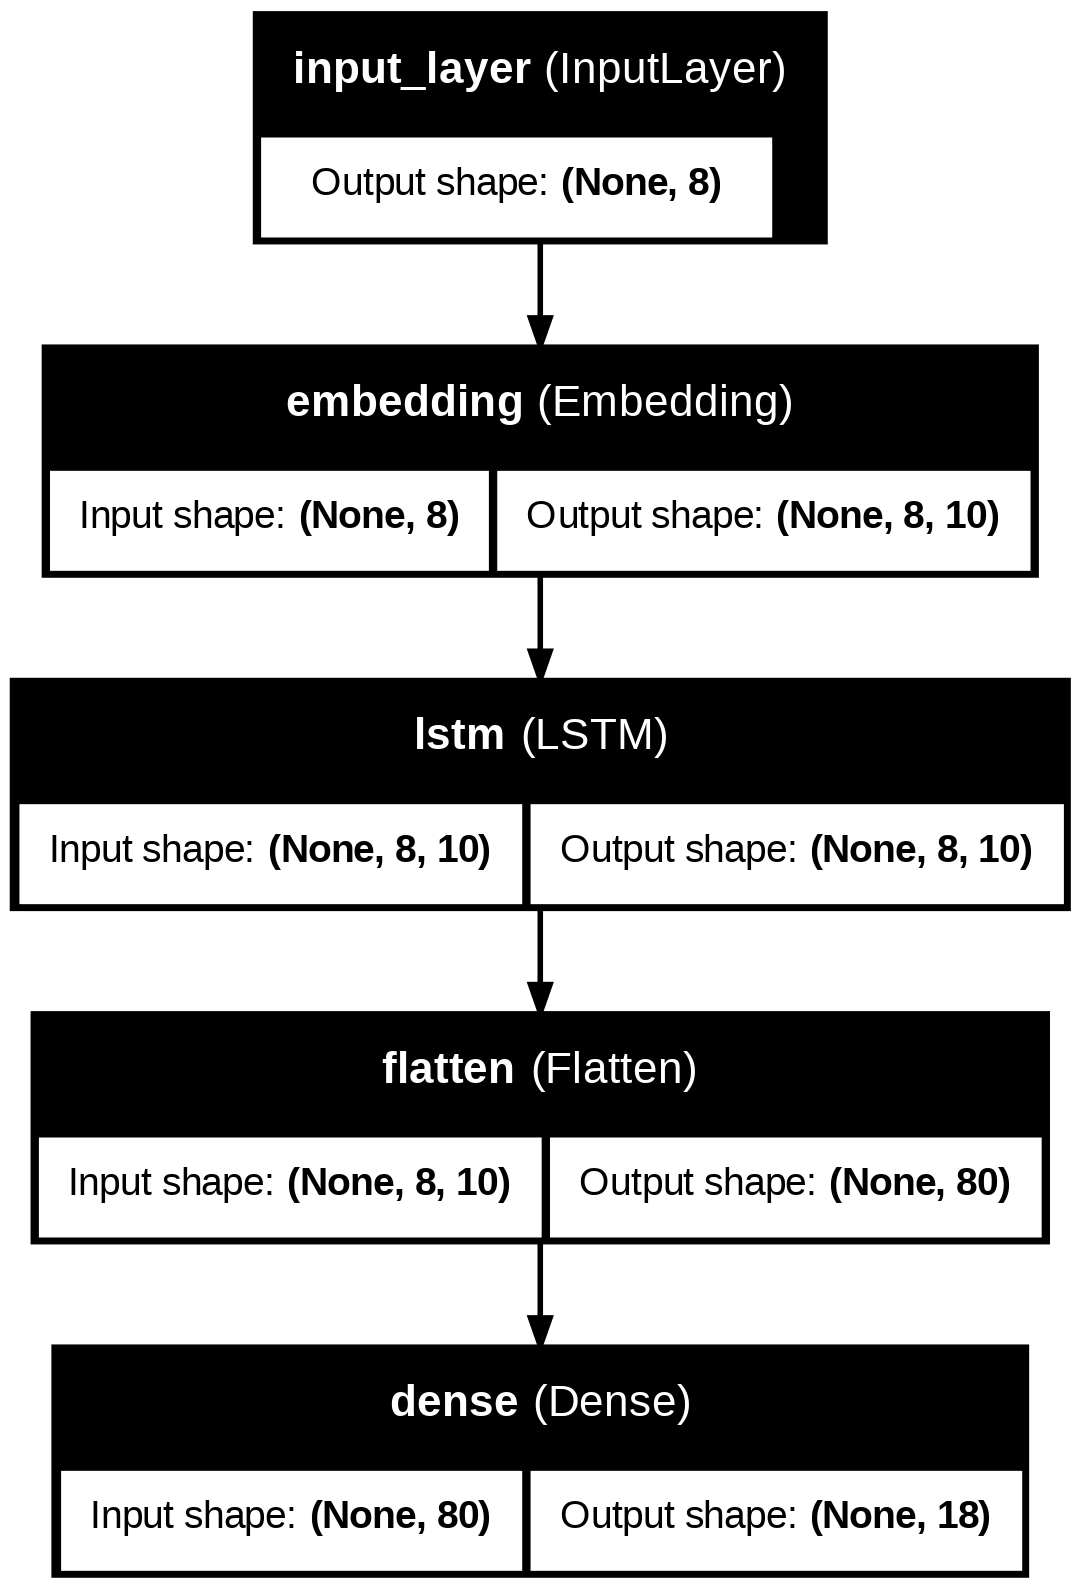

In [ ]:
# Visualisasi Plot Arsitektur Model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Menampilkan parameter pada model LSTM
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 8, 10)               │             810 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8, 10)               │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 18)                  │           1,458 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,108 (12.14 KB)

 Trainable params: 3,108 (12.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Melatih model data dengan 500 epoch
train = model.fit(x_train, y_train, epochs=500)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.0417 - loss: 2.8918
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0833 - loss: 2.8878
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1667 - loss: 2.8844 
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1146 - loss: 2.8811
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1042 - loss: 2.8772
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1354 - loss: 2.8713 
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1146 - loss: 2.8701 
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1250 - loss: 2.8633
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0938 - loss: 2.8614 
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1250 - loss: 2.8527 
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1042 - loss: 2.8456 
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.114

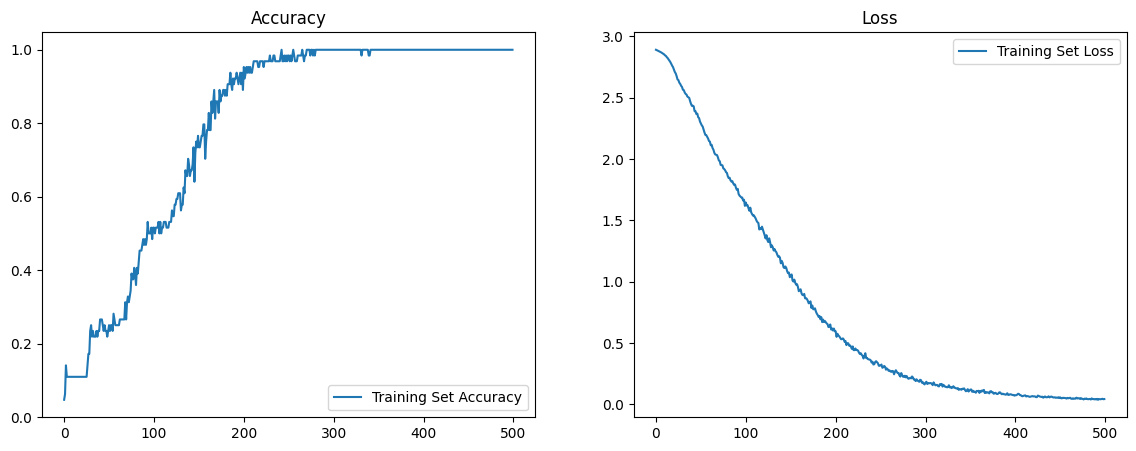

In [ ]:
# Visualisasi Plot Hasil Akurasi dan Loss
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [ ]:
import random
import string
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

while True:
    texts_p = []
    prediction_input = input('👨‍🦰 Unib Tribe : ')

    # Menghapus punktuasi atau tanda baca dan konversi ke huruf kecil
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts_p.append(prediction_input)

    # Melakukan Tokenisasi dan Padding pada data teks
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    # Konversi data teks menjadi array
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    # Mendapatkan hasil prediksi keluaran pada model
    output = model.predict(prediction_input)
    output = output.argmax()

    # Menemukan respon sesuai data tag
    response_tag = le.inverse_transform([output])[0]
    # Chat Bot akan melakukan random jawaban percakapan dari hasil pertanyaan
    print("SahabatUnib : ", random.choice(responses[response_tag]))

    print("="*60 + "\n")
    # Tambahkan respon 'goodbye' agar bot bisa berhenti melakukan percakapan saat menggunakan kata yang sesuai data tag "goodbye"
    if response_tag == "goodbye":
        break


👨‍🦰 Unib Tribe : halo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
SahabatUnib :  Halo! Saya SahabatUnib, salam kenal ya! Mau tau tentang Universitas Bengkulu?

👨‍🦰 Unib Tribe : ceritakan sejarah universitas bengkulu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
SahabatUnib :  Universitas Bengkulu (UNIB) didirikan berdasarkan Keputusan Presiden RI Nomor 17 Tahun 1982 dan diresmikan oleh Menteri Pendidikan dan Kebudayaan Republik Indonesia, Prof. Dr. Daud Yusuf. Rektor pertama UNIB adalah Prof. Ir. Soenjoto Sumodihardjo (UGM), yang menjabat dari 1982 hingga 1986. Pendirian UNIB merupakan hasil perjuangan Gubernur Soeprapto bersama masyarakat dan tokoh adat Bengkulu, dengan dukungan perguruan tinggi swasta Universitas Semarak Bengkulu (UNSEB).

👨‍🦰 Unib Tribe : rektor unib dari dulu sampai searang
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
SahabatUnib :  Berikut adalah daftar rektor Universitas Bengkulu: 
1. Prof. Ir. Soenjoto Sumodihardjo (1982–1986)
2. Dr. Ir. Soekotjo (1986–1990)
3. Dr. Ir. Nitza Arbi (1

In [ ]:
# Simpan model dalam format HDF5
model.save('/content/drive/My Drive/deepl_model.keras')  # Ganti path sesuai dengan lokasi yang Anda inginkan
